In [1]:
# Initial Setup - Clear previous results
from helper import clear_folder

clear_folder("ray_results")
clear_folder("outputs")
clear_folder("results")

print("Previous results cleared successfully!")

Previous results cleared successfully!


# Autoencoder-SVM with Separate Optuna Optimization

This notebook implements a Autoencoder-SVM pipeline with separate Optuna optimization for both components:
1. **Autoencoder Optimization**: Finds optimal autoencoder architecture using Leave-One-Out cross-validation
2. **SVM Optimization**: Finds optimal SVM hyperparameters on encoded features using stratified cross-validation

The approach ensures both feature representation and classification are optimally tuned for each dataset.

In [2]:
# Imports and Configuration
import os
import json
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, Tuple, List
import warnings
from collections import Counter
from statistics import mean, stdev

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold

# Optuna imports
import optuna
from optuna.pruners import MedianPruner, PatientPruner
from optuna.samplers import TPESampler

# Configure warnings and logging
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Configuration
RANDOM_STATE = 42
RESULTS_DIR = "results"
BASE_DATA_PATH = os.path.join("data", "normalized")
DATASETS = ["A2", "A3", "A4", "A12", "A21"]

# Autoencoder trial configuration
AE_TRIAL_CONFIG = {
    "A2": {"n_trials": 50, "timeout_min": 8},
    "A3": {"n_trials": 50, "timeout_min": 8},
    "A4": {"n_trials": 75, "timeout_min": 10},
    "A12": {"n_trials": 100, "timeout_min": 15},
    "A21": {"n_trials": 50, "timeout_min": 8}
}

# SVM trial configuration (enhanced based on Classic-SVM experience)
SVM_TRIAL_CONFIG = {
    "A2": {"n_trials": 150, "timeout_min": 8, "per_trial_time": 45},    # 2 classes
    "A3": {"n_trials": 150, "timeout_min": 8, "per_trial_time": 45},    # 2 classes  
    "A4": {"n_trials": 200, "timeout_min": 10, "per_trial_time": 60},   # 3 classes
    "A12": {"n_trials": 250, "timeout_min": 15, "per_trial_time": 90},  # 6 classes (challenging)
    "A21": {"n_trials": 150, "timeout_min": 8, "per_trial_time": 45}    # 2 classes
}

os.makedirs(RESULTS_DIR, exist_ok=True)
print("Configuration loaded successfully!")
print(f"Datasets to process: {DATASETS}")
print(f"Results will be saved to: {RESULTS_DIR}")
print(f"Autoencoder trials: {[AE_TRIAL_CONFIG[d]['n_trials'] for d in DATASETS]}")
print(f"SVM trials: {[SVM_TRIAL_CONFIG[d]['n_trials'] for d in DATASETS]}")

Configuration loaded successfully!
Datasets to process: ['A2', 'A3', 'A4', 'A12', 'A21']
Results will be saved to: results
Autoencoder trials: [50, 50, 75, 100, 50]
SVM trials: [150, 150, 200, 250, 150]


In [3]:
# Data Preparation
# File paths for the normalized datasets
filenames = [
    'data/normalized/A2.csv', 
    'data/normalized/A3.csv', 
    'data/normalized/A4.csv', 
    'data/normalized/A12.csv', 
    'data/normalized/A21.csv'
]

# Load datasets
datasets = [pd.read_csv(f) for f in filenames]

# Split into features and target
features_list = []
targets_list = []
for df in datasets:
    features_list.append(df[[str(i) for i in range(30)]])  # 30 features
    targets_list.append(df["track"])

# Extract dataset names
dataset_names = [os.path.splitext(os.path.basename(f))[0] for f in filenames]

# Dataset information
print("Dataset Information:")
for i, (name, features, targets) in enumerate(zip(dataset_names, features_list, targets_list)):
    n_samples, n_features = features.shape
    n_classes = len(targets.unique())
    class_counts = targets.value_counts().sort_index()
    print(f"  {name}: {n_samples} samples, {n_features} features, {n_classes} classes")
    print(f"    Class distribution: {dict(class_counts)}")
    
print(f"\nTotal datasets loaded: {len(datasets)}")

Dataset Information:
  A2: 536 samples, 30 features, 2 classes
    Class distribution: {'Track3': 268, 'Track4': 268}
  A3: 346 samples, 30 features, 2 classes
    Class distribution: {'Track1': 173, 'Track2': 173}
  A4: 1966 samples, 30 features, 3 classes
    Class distribution: {'Track1': 647, 'Track2': 632, 'Track4': 687}
  A12: 1932 samples, 30 features, 6 classes
    Class distribution: {'Track11': 323, 'Track13': 318, 'Track15': 322, 'Track3': 321, 'Track7': 324, 'Track8': 324}
  A21: 526 samples, 30 features, 2 classes
    Class distribution: {'Track3': 218, 'Track4': 308}

Total datasets loaded: 5


In [4]:
# Utility Functions
def save_json(obj: Any, path: str):
    """Save object as JSON with directory creation."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def load_json(path: str) -> Any:
    """Load object from JSON file."""
    with open(path, "r") as f:
        return json.load(f)

def evaluate_metrics(y_true, y_pred) -> Dict[str, float]:
    """Calculate comprehensive evaluation metrics."""
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "micro_f1": float(f1_score(y_true, y_pred, average="micro")),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
        "mcc": float(matthews_corrcoef(y_true, y_pred)),
    }

def get_ae_pruner():
    """Get configured pruner for Autoencoder Optuna."""
    return PatientPruner(
        MedianPruner(n_warmup_steps=3), patience=5, min_delta=1e-5
    )

def get_svm_pruner():
    """Get configured pruner for SVM Optuna."""
    return PatientPruner(
        MedianPruner(n_warmup_steps=5), patience=8, min_delta=1e-4
    )

def get_sampler():
    """Get configured sampler for Optuna."""
    return TPESampler(seed=RANDOM_STATE, multivariate=True, group=True)

def make_stratified_split(X: np.ndarray, y: np.ndarray, test_size: float = 0.2) -> Tuple[np.ndarray, ...]:
    """Create stratified train/validation split."""
    return train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=RANDOM_STATE
    )

print("Utility functions defined successfully!")

Utility functions defined successfully!


# Phase 1: Autoencoder Architecture and Optimization

In [5]:
# Autoencoder Architecture
class Autoencoder(nn.Module):
    """Flexible autoencoder with configurable architecture."""
    
    def __init__(self, layer_sizes: List[int], dropout_rate: float = 0.0):
        super(Autoencoder, self).__init__()
        self.layer_sizes = layer_sizes
        
        # Build encoder
        encoder_layers = []
        for i in range(len(layer_sizes) - 1):
            encoder_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # No activation after bottleneck
                encoder_layers.append(nn.ReLU())
                if dropout_rate > 0:
                    encoder_layers.append(nn.Dropout(dropout_rate))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Build decoder (reverse of encoder)
        decoder_layers = []
        reversed_sizes = layer_sizes[::-1]
        for i in range(len(reversed_sizes) - 1):
            decoder_layers.append(nn.Linear(reversed_sizes[i], reversed_sizes[i + 1]))
            if i < len(reversed_sizes) - 2:  # No activation after output
                decoder_layers.append(nn.ReLU())
                if dropout_rate > 0:
                    decoder_layers.append(nn.Dropout(dropout_rate))
        self.decoder = nn.Sequential(*decoder_layers)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Get encoded representation."""
        return self.encoder(x)

print("Autoencoder class defined successfully!")

Autoencoder class defined successfully!


In [6]:
# Autoencoder Optimization Functions
def suggest_ae_params(trial: optuna.Trial, dataset_name: str) -> Dict[str, Any]:
    """Suggest autoencoder hyperparameters."""
    # Architecture parameters
    hidden_dim = trial.suggest_int("hidden_dim", 10, 30)
    bottleneck_dim = trial.suggest_int("bottleneck_dim", 2, hidden_dim - 1)
    
    # Training parameters
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.3)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    
    # Training schedule
    epochs = trial.suggest_int("epochs", 30, 80)
    
    return {
        "layer_sizes": [30, hidden_dim, bottleneck_dim],
        "dropout_rate": dropout_rate,
        "lr": lr,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "epochs": epochs
    }

def train_autoencoder_trial(trial: optuna.Trial, dataset_idx: int, dataset_name: str) -> float:
    """Train autoencoder for a single Optuna trial."""
    params = suggest_ae_params(trial, dataset_name)
    
    # Prepare Leave-One-Out training data
    train_features = pd.concat(
        [features_list[j] for j in range(len(datasets)) if j != dataset_idx],
        axis=0
    )
    
    # Convert to tensor
    X_tensor = torch.tensor(train_features.values, dtype=torch.float32)
    loader = DataLoader(
        TensorDataset(X_tensor), 
        batch_size=params["batch_size"], 
        shuffle=True
    )
    
    # Initialize model
    model = Autoencoder(params["layer_sizes"], params["dropout_rate"])
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params["lr"], 
        weight_decay=params["weight_decay"]
    )
    criterion = nn.MSELoss()
    
    # Training with early stopping and progress reporting
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    patience = 10
    
    for epoch in range(params["epochs"]):
        epoch_loss = 0
        n_batches = 0
        
        for batch in loader:
            x = batch[0]
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed = model(x)
            loss = criterion(reconstructed, x)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_loss = epoch_loss / n_batches
        
        # Report for pruning (every 5 epochs)
        if epoch % 5 == 0:
            trial.report(avg_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    # Save model and configuration
    model_path = f"{RESULTS_DIR}/ae_models/autoencoder_trial_{dataset_name}_{trial.number}.pt"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(model.state_dict(), model_path)
    
    trial.set_user_attr("model_path", model_path)
    trial.set_user_attr("params", params)
    trial.set_user_attr("final_epoch", epoch)
    
    return best_loss

print("Autoencoder optimization functions defined!")

Autoencoder optimization functions defined!


In [7]:
# Execute Autoencoder Optimization
print("Starting Autoencoder optimization for all datasets...")
print("=" * 60)

ae_results = {}
ae_total_start = time.time()

for i, dataset_name in enumerate(dataset_names):
    print(f"\n🔍 Autoencoder Optuna optimization for: {dataset_name}")
    
    # Get configuration
    config = AE_TRIAL_CONFIG[dataset_name]
    n_trials = config["n_trials"]
    timeout_sec = config["timeout_min"] * 60
    
    print(f"Configuration: {n_trials} trials, {config['timeout_min']} min timeout")
    
    # Create objective function
    def objective(trial):
        return train_autoencoder_trial(trial, dataset_idx=i, dataset_name=dataset_name)
    
    # Setup Optuna study
    study = optuna.create_study(
        direction="minimize",
        sampler=get_sampler(),
        pruner=get_ae_pruner(),
        study_name=f"Autoencoder_{dataset_name}"
    )
    
    # Run optimization
    start_time = time.time()
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=timeout_sec,
        show_progress_bar=True
    )
    elapsed_time = time.time() - start_time
    
    # Collect results
    best_trial = study.best_trial
    n_completed = sum(1 for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE)
    n_pruned = sum(1 for t in study.trials if t.state == optuna.trial.TrialState.PRUNED)
    
    result = {
        "dataset": dataset_name,
        "n_completed_trials": n_completed,
        "n_pruned_trials": n_pruned,
        "elapsed_sec": elapsed_time,
        "best_loss": best_trial.value if best_trial else None,
        "best_params": best_trial.user_attrs.get("params", {}) if best_trial else {},
        "best_model_path": best_trial.user_attrs.get("model_path", "") if best_trial else "",
        "final_epoch": best_trial.user_attrs.get("final_epoch", 0) if best_trial else 0
    }
    
    ae_results[dataset_name] = result
    
    # Save individual results
    study_dir = f"{RESULTS_DIR}/ae_optuna_results_{dataset_name}"
    os.makedirs(study_dir, exist_ok=True)
    save_json(result, f"{study_dir}/summary.json")
    
    print(f"  Completed: {n_completed} trials, Pruned: {n_pruned} trials")
    print(f"  Best loss: {result['best_loss']:.6f}" if result['best_loss'] else "  No successful trials")
    print(f"  Elapsed time: {elapsed_time:.1f} seconds")
    
    if best_trial:
        params = result['best_params']
        print(f"  Best architecture: {params['layer_sizes']}")
        print(f"  Best LR: {params['lr']:.2e}, Dropout: {params['dropout_rate']:.3f}")

ae_total_elapsed = time.time() - ae_total_start

# Save consolidated autoencoder results
save_json(ae_results, f"{RESULTS_DIR}/ae_optimization_results.json")

print(f"\n{'=' * 60}")
print("AUTOENCODER OPTIMIZATION SUMMARY")
print(f"{'=' * 60}")
print(f"Total time: {ae_total_elapsed:.1f} seconds ({ae_total_elapsed/60:.1f} minutes)")
print(f"Successfully optimized: {sum(1 for r in ae_results.values() if r['best_loss'] is not None)}/{len(ae_results)} datasets")

# Create summary dataframe
ae_summary_data = []
for result in ae_results.values():
    if result['best_loss'] is not None:
        params = result['best_params']
        ae_summary_data.append({
            "Dataset": result['dataset'],
            "Best_Loss": f"{result['best_loss']:.6f}",
            "Architecture": f"{params['layer_sizes']}",
            "Learning_Rate": f"{params['lr']:.2e}",
            "Dropout": f"{params['dropout_rate']:.3f}",
            "Trials": result['n_completed_trials']
        })

if ae_summary_data:
    ae_df = pd.DataFrame(ae_summary_data)
    print(f"\nAutoencoder optimization results:")
    display(ae_df)
    ae_df.to_csv(f"{RESULTS_DIR}/ae_summary_results.csv", index=False)

print(f"\nAutoencoder results saved to: {RESULTS_DIR}/ae_optimization_results.json")

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_30514/3719552500.py:24: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:15:11,172] A new study created in memory with name: Autoencoder_A2


Starting Autoencoder optimization for all datasets...

🔍 Autoencoder Optuna optimization for: A2
Configuration: 50 trials, 8 min timeout


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-04 08:15:15,507] Trial 0 finished with value: 0.017054781221474212 and parameters: {'hidden_dim': 17, 'bottleneck_dim': 16, 'lr': 0.0029106359131330704, 'batch_size': 32, 'dropout_rate': 0.017425083650459836, 'weight_decay': 0.0003967605077052988, 'epochs': 60}. Best is trial 0 with value: 0.017054781221474212.
[I 2025-09-04 08:15:18,615] Trial 1 finished with value: 0.06372160592426857 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.017054781221474212.
[I 2025-09-04 08:15:18,615] Trial 1 finished with value: 0.06372160592426857 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.017054781221474212.
[I 2025-09-04 08:15:19,637] Trial 

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_30514/3719552500.py:24: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:17:58,151] A new study created in memory with name: Autoencoder_A3


[I 2025-09-04 08:17:58,144] Trial 49 finished with value: 0.004494082825258375 and parameters: {'hidden_dim': 17, 'bottleneck_dim': 16, 'lr': 0.005643335948525138, 'batch_size': 64, 'dropout_rate': 0.0009146966103890316, 'weight_decay': 1.6595036001943696e-06, 'epochs': 79}. Best is trial 40 with value: 0.002512960754490147.
  Completed: 50 trials, Pruned: 0 trials
  Best loss: 0.002513
  Elapsed time: 167.0 seconds
  Best architecture: [30, 26, 14]
  Best LR: 1.04e-03, Dropout: 0.000

🔍 Autoencoder Optuna optimization for: A3
Configuration: 50 trials, 8 min timeout


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-04 08:18:00,202] Trial 0 finished with value: 0.020035942553752854 and parameters: {'hidden_dim': 17, 'bottleneck_dim': 16, 'lr': 0.0029106359131330704, 'batch_size': 32, 'dropout_rate': 0.017425083650459836, 'weight_decay': 0.0003967605077052988, 'epochs': 60}. Best is trial 0 with value: 0.020035942553752854.
[I 2025-09-04 08:18:04,226] Trial 1 finished with value: 0.06193589435950402 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.020035942553752854.
[I 2025-09-04 08:18:04,226] Trial 1 finished with value: 0.06193589435950402 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.020035942553752854.
[I 2025-09-04 08:18:05,261] Trial 

[I 2025-09-04 08:20:35,882] A new study created in memory with name: Autoencoder_A4


[I 2025-09-04 08:20:35,874] Trial 49 finished with value: 0.04136518230361323 and parameters: {'hidden_dim': 16, 'bottleneck_dim': 5, 'lr': 0.009223438471091996, 'batch_size': 32, 'dropout_rate': 0.08870261091029306, 'weight_decay': 4.861626337822738e-06, 'epochs': 58}. Best is trial 21 with value: 0.004363454200868164.
  Completed: 50 trials, Pruned: 0 trials
  Best loss: 0.004363
  Elapsed time: 157.7 seconds
  Best architecture: [30, 24, 15]
  Best LR: 4.17e-03, Dropout: 0.004

🔍 Autoencoder Optuna optimization for: A4
Configuration: 75 trials, 10 min timeout


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-09-04 08:20:38,308] Trial 0 finished with value: 0.01996239504466454 and parameters: {'hidden_dim': 17, 'bottleneck_dim': 16, 'lr': 0.0029106359131330704, 'batch_size': 32, 'dropout_rate': 0.017425083650459836, 'weight_decay': 0.0003967605077052988, 'epochs': 60}. Best is trial 0 with value: 0.01996239504466454.
[I 2025-09-04 08:20:39,954] Trial 1 finished with value: 0.0652183679952508 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.01996239504466454.
[I 2025-09-04 08:20:39,954] Trial 1 finished with value: 0.0652183679952508 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.01996239504466454.
[I 2025-09-04 08:20:40,669] Trial 2 fini

[I 2025-09-04 08:22:51,823] A new study created in memory with name: Autoencoder_A12


[I 2025-09-04 08:22:51,813] Trial 74 finished with value: 0.018934328660920815 and parameters: {'hidden_dim': 27, 'bottleneck_dim': 11, 'lr': 0.0015467041027104084, 'batch_size': 128, 'dropout_rate': 0.037729218001882586, 'weight_decay': 2.077398750121566e-06, 'epochs': 37}. Best is trial 45 with value: 0.002598527436410742.
  Completed: 75 trials, Pruned: 0 trials
  Best loss: 0.002599
  Elapsed time: 135.9 seconds
  Best architecture: [30, 29, 14]
  Best LR: 4.91e-03, Dropout: 0.000

🔍 Autoencoder Optuna optimization for: A12
Configuration: 100 trials, 15 min timeout


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-04 08:22:53,224] Trial 0 finished with value: 0.015492552425712347 and parameters: {'hidden_dim': 17, 'bottleneck_dim': 16, 'lr': 0.0029106359131330704, 'batch_size': 32, 'dropout_rate': 0.017425083650459836, 'weight_decay': 0.0003967605077052988, 'epochs': 60}. Best is trial 0 with value: 0.015492552425712347.
[I 2025-09-04 08:22:56,001] Trial 1 finished with value: 0.04316061830042668 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.015492552425712347.
[I 2025-09-04 08:22:56,001] Trial 1 finished with value: 0.04316061830042668 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.015492552425712347.
[I 2025-09-04 08:22:56,722] Trial 

[I 2025-09-04 08:26:51,728] A new study created in memory with name: Autoencoder_A21


[I 2025-09-04 08:26:51,715] Trial 99 finished with value: 0.009023287487304155 and parameters: {'hidden_dim': 30, 'bottleneck_dim': 16, 'lr': 0.002711443685091463, 'batch_size': 32, 'dropout_rate': 0.04557330183651549, 'weight_decay': 7.73448021316149e-06, 'epochs': 74}. Best is trial 94 with value: 0.0019404734012600526.
  Completed: 100 trials, Pruned: 0 trials
  Best loss: 0.001940
  Elapsed time: 239.9 seconds
  Best architecture: [30, 26, 15]
  Best LR: 1.70e-03, Dropout: 0.001

🔍 Autoencoder Optuna optimization for: A21
Configuration: 50 trials, 8 min timeout


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-04 08:26:55,869] Trial 0 finished with value: 0.02015770211815834 and parameters: {'hidden_dim': 17, 'bottleneck_dim': 16, 'lr': 0.0029106359131330704, 'batch_size': 32, 'dropout_rate': 0.017425083650459836, 'weight_decay': 0.0003967605077052988, 'epochs': 60}. Best is trial 0 with value: 0.02015770211815834.
[I 2025-09-04 08:26:58,688] Trial 1 finished with value: 0.06521002903580665 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.02015770211815834.
[I 2025-09-04 08:26:58,688] Trial 1 finished with value: 0.06521002903580665 and parameters: {'hidden_dim': 24, 'bottleneck_dim': 2, 'lr': 0.008706020878304856, 'batch_size': 32, 'dropout_rate': 0.055021352956030146, 'weight_decay': 8.179499475211674e-06, 'epochs': 56}. Best is trial 0 with value: 0.02015770211815834.
[I 2025-09-04 08:26:59,726] Trial 2 fi

,Dataset,Best_Loss,Architecture,Learning_Rate,Dropout,Trials
0,A2,0.002513,"[30, 26, 14]",1.04e-03,0.000,50
1,A3,0.004363,"[30, 24, 15]",4.17e-03,0.004,50
2,A4,0.002599,"[30, 29, 14]",4.91e-03,0.000,75
3,A12,0.001940,"[30, 26, 15]",1.70e-03,0.001,100
4,A21,0.003329,"[30, 25, 14]",4.37e-03,0.001,50



Autoencoder results saved to: results/ae_optimization_results.json


# Phase 2: SVM Hyperparameter Optimization on Encoded Features

Now we'll use the optimized autoencoders to encode features and then optimize SVM hyperparameters on the encoded representations.

In [8]:
# SVM Optimization Functions
def suggest_svm_params(trial: optuna.Trial, dataset_name: str, n_classes: int) -> Dict[str, Any]:
    """Suggest SVM hyperparameters with dataset-specific adaptations."""
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear", "poly", "sigmoid"])
    
    # C parameter - log scale for wide range
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    
    # Gamma parameter - with constraints to prevent hanging
    if kernel in ["rbf", "poly", "sigmoid"]:
        gamma_choice = trial.suggest_categorical("gamma_choice", ["auto", "scale", "float"])
        if gamma_choice == "float":
            # Constrain gamma range to prevent extreme values
            gamma = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
        else:
            gamma = gamma_choice
    else:
        # Linear kernel doesn't use gamma
        gamma = "scale"
    
    # Kernel-specific parameters
    degree = trial.suggest_int("degree", 2, 4) if kernel == "poly" else 3
    coef0 = trial.suggest_float("coef0", -1.0, 1.0) if kernel in ["poly", "sigmoid"] else 0.0
    
    # Additional parameters with constraints
    shrinking = trial.suggest_categorical("shrinking", [True, False])
    tol = trial.suggest_float("tol", 1e-4, 1e-2, log=True)
    
    # Max iterations to prevent infinite training
    max_iter = trial.suggest_categorical("max_iter", [1000, 2000, 5000])
    
    # Class weight for imbalanced datasets (especially A12)
    if n_classes > 3:  # Multi-class datasets
        class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    else:
        class_weight = None
    
    return {
        "kernel": kernel, "C": C, "gamma": gamma, "degree": degree, 
        "coef0": coef0, "shrinking": shrinking, "tol": tol, 
        "class_weight": class_weight, "max_iter": max_iter
    }

def build_svm_pipeline(params: Dict[str, Any]) -> Pipeline:
    """Build SVM pipeline with proper scaling."""
    svc = SVC(
        random_state=RANDOM_STATE,
        cache_size=400,
        **params
    )
    # Add StandardScaler for numerical stability on encoded features
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", svc)
    ])

def train_svm_trial(trial: optuna.Trial, encoded_features: np.ndarray, targets: np.ndarray, 
                   dataset_name: str, per_trial_time_limit: int = 60) -> float:
    """Train SVM for a single Optuna trial using 3-fold CV."""
    n_classes = len(np.unique(targets))
    params = suggest_svm_params(trial, dataset_name, n_classes)
    pipeline = build_svm_pipeline(params)
    
    # Encode targets
    le = LabelEncoder()
    y_encoded = le.fit_transform(targets)
    
    # 3-fold stratified CV for optimization (balance between speed and reliability)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("n_classes", n_classes)
    
    start_time = time.time()
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(encoded_features, y_encoded)):
        # Check timeout
        if time.time() - start_time > per_trial_time_limit:
            print(f"Trial {trial.number}: Timeout at fold {fold_idx}")
            raise optuna.TrialPruned()
        
        X_train_cv, X_val_cv = encoded_features[train_idx], encoded_features[val_idx]
        y_train_cv, y_val_cv = y_encoded[train_idx], y_encoded[val_idx]
        
        try:
            # Time the fitting process
            fit_start = time.time()
            pipeline.fit(X_train_cv, y_train_cv)
            fit_time = time.time() - fit_start
            
            # If fitting took too long, penalize
            if fit_time > per_trial_time_limit / 3:
                print(f"Trial {trial.number}: Slow fit at fold {fold_idx} ({fit_time:.1f}s)")
                return 0.05  # Low penalty score
            
            # Predict and evaluate
            y_pred_cv = pipeline.predict(X_val_cv)
            score = accuracy_score(y_val_cv, y_pred_cv)
            cv_scores.append(score)
            
            # Report intermediate result
            trial.report(np.mean(cv_scores), fold_idx)
            trial.set_user_attr(f"fold_{fold_idx}_score", score)
            trial.set_user_attr(f"fold_{fold_idx}_fit_time", fit_time)
            
            # Check if should prune
            if trial.should_prune():
                print(f"Trial {trial.number}: Pruned at fold {fold_idx}")
                raise optuna.TrialPruned()
                
        except optuna.TrialPruned:
            raise
        except Exception as e:
            error_msg = str(e).lower()
            if any(keyword in error_msg for keyword in ["convergence", "max_iter", "iteration", "solver"]):
                print(f"Trial {trial.number}: Convergence issue at fold {fold_idx}")
                return 0.1  # Low score for convergence issues
            else:
                print(f"Trial {trial.number}: Error at fold {fold_idx}: {e}")
                raise optuna.TrialPruned()
    
    mean_score = np.mean(cv_scores)
    trial.set_user_attr("cv_scores", cv_scores)
    trial.set_user_attr("mean_score", mean_score)
    trial.set_user_attr("std_score", np.std(cv_scores))
    trial.set_user_attr("total_time", time.time() - start_time)
    
    print(f"Trial {trial.number}: Completed (score={mean_score:.3f}±{np.std(cv_scores):.3f})")
    return mean_score

print("SVM optimization functions defined!")

SVM optimization functions defined!


In [9]:
# Execute SVM Optimization on Encoded Features
print("Starting SVM optimization on encoded features...")
print("=" * 60)

svm_results = {}
svm_total_start = time.time()

for dataset_name in dataset_names:
    print(f"\n🎯 SVM Optuna optimization for: {dataset_name}")
    
    # Check if autoencoder optimization was successful
    if dataset_name not in ae_results or ae_results[dataset_name]['best_loss'] is None:
        print(f"  Skipping {dataset_name} - no successful autoencoder optimization")
        continue
    
    # Load best autoencoder
    ae_result = ae_results[dataset_name]
    best_params = ae_result['best_params']
    model_path = ae_result['best_model_path']
    
    # Recreate and load autoencoder
    autoencoder = Autoencoder(best_params['layer_sizes'], best_params['dropout_rate'])
    autoencoder.load_state_dict(torch.load(model_path))
    autoencoder.eval()
    
    # Get dataset index and encode features
    dataset_idx = dataset_names.index(dataset_name)
    features = features_list[dataset_idx]
    targets = targets_list[dataset_idx]
    
    # Encode features using best autoencoder
    X_tensor = torch.tensor(features.values, dtype=torch.float32)
    with torch.no_grad():
        encoded_features = autoencoder.encode(X_tensor).numpy()
    
    print(f"  Original features: {features.shape}, Encoded features: {encoded_features.shape}")
    
    # Get SVM configuration
    config = SVM_TRIAL_CONFIG[dataset_name]
    n_trials = config["n_trials"]
    timeout_sec = config["timeout_min"] * 60
    per_trial_time = config["per_trial_time"]
    
    print(f"  Configuration: {n_trials} trials, {config['timeout_min']} min timeout, {per_trial_time}s per trial")
    
    # Create objective function
    def objective(trial):
        return train_svm_trial(trial, encoded_features, targets.values, dataset_name, per_trial_time)
    
    # Setup Optuna study
    study = optuna.create_study(
        direction="maximize",
        sampler=get_sampler(),
        pruner=get_svm_pruner(),
        study_name=f"SVM_{dataset_name}"
    )
    
    # Run optimization
    start_time = time.time()
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=timeout_sec,
        show_progress_bar=True
    )
    elapsed_time = time.time() - start_time
    
    # Collect results
    best_trial = study.best_trial if len(study.trials) > 0 else None
    n_completed = sum(1 for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE)
    n_pruned = sum(1 for t in study.trials if t.state == optuna.trial.TrialState.PRUNED)
    
    result = {
        "dataset": dataset_name,
        "n_completed_trials": n_completed,
        "n_pruned_trials": n_pruned,
        "elapsed_sec": elapsed_time,
        "best_accuracy": best_trial.value if best_trial else None,
        "best_params": best_trial.user_attrs.get("params", {}) if best_trial else {},
        "cv_scores": best_trial.user_attrs.get("cv_scores", []) if best_trial else [],
        "encoded_shape": encoded_features.shape,
        "n_classes": len(np.unique(targets))
    }
    
    svm_results[dataset_name] = result
    
    # Save individual results
    study_dir = f"{RESULTS_DIR}/svm_optuna_results_{dataset_name}"
    os.makedirs(study_dir, exist_ok=True)
    save_json(result, f"{study_dir}/summary.json")
    
    print(f"  Completed: {n_completed} trials, Pruned: {n_pruned} trials")
    print(f"  Best accuracy: {result['best_accuracy']:.4f}" if result['best_accuracy'] else "  No successful trials")
    print(f"  Elapsed time: {elapsed_time:.1f} seconds")
    
    if best_trial:
        params = result['best_params']
        cv_scores = result['cv_scores']
        print(f"  Best SVM: {params['kernel']} kernel, C={params['C']:.3f}, gamma={params['gamma']}")
        print(f"  CV scores: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

svm_total_elapsed = time.time() - svm_total_start

# Save consolidated SVM results
save_json(svm_results, f"{RESULTS_DIR}/svm_optimization_results.json")

print(f"\n{'=' * 60}")
print("SVM OPTIMIZATION SUMMARY")
print(f"{'=' * 60}")
print(f"Total time: {svm_total_elapsed:.1f} seconds ({svm_total_elapsed/60:.1f} minutes)")
print(f"Successfully optimized: {sum(1 for r in svm_results.values() if r['best_accuracy'] is not None)}/{len(svm_results)} datasets")

# Create summary dataframe
svm_summary_data = []
for result in svm_results.values():
    if result['best_accuracy'] is not None:
        params = result['best_params']
        cv_scores = result['cv_scores']
        svm_summary_data.append({
            "Dataset": result['dataset'],
            "Best_Accuracy": f"{result['best_accuracy']:.4f}",
            "CV_Std": f"{np.std(cv_scores):.4f}",
            "Kernel": params['kernel'],
            "C": f"{params['C']:.3f}",
            "Gamma": str(params['gamma']),
            "Encoded_Dims": result['encoded_shape'][1],
            "Trials": result['n_completed_trials']
        })

if svm_summary_data:
    svm_df = pd.DataFrame(svm_summary_data)
    print(f"\nSVM optimization results:")
    display(svm_df)
    svm_df.to_csv(f"{RESULTS_DIR}/svm_summary_results.csv", index=False)

print(f"\nSVM results saved to: {RESULTS_DIR}/svm_optimization_results.json")

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_30514/3719552500.py:30: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:29:56,390] A new study created in memory with name: SVM_A2


Starting SVM optimization on encoded features...

🎯 SVM Optuna optimization for: A2
  Original features: (536, 30), Encoded features: (536, 14)
  Configuration: 150 trials, 8 min timeout, 45s per trial


  0%|          | 0/150 [00:00<?, ?it/s]

Trial 0: Completed (score=0.772±0.038)
[I 2025-09-04 08:29:56,407] Trial 0 finished with value: 0.7724143703052748 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 2000}. Best is trial 0 with value: 0.7724143703052748.
Trial 1: Completed (score=0.612±0.163)
[I 2025-09-04 08:29:56,431] Trial 1 finished with value: 0.6123700123449041 and parameters: {'kernel': 'rbf', 'C': 0.012601639723276799, 'gamma_choice': 'scale', 'shrinking': False, 'tol': 0.00019010245319870352, 'max_iter': 5000}. Best is trial 0 with value: 0.7724143703052748.
Trial 2: Completed (score=0.612±0.163)
[I 2025-09-04 08:29:56,454] Trial 2 finished with value: 0.6123700123449041 and parameters: {'kernel': 'rbf', 'C': 0.0018997763474111276, 'gamma_choice': 'auto', 'shrinking': False, 'tol': 0.004138040112561018, 'max_iter': 5000}. Best is trial 0 with value: 0.7724143703052748.
Trial 3: Completed (score=0.774±0.002)
[I 2025-09-04 08:29:56,466] Tri

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_30514/3719552500.py:30: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:30:00,096] A new study created in memory with name: SVM_A3


Trial 149: Completed (score=0.843±0.020)
[I 2025-09-04 08:30:00,067] Trial 149 finished with value: 0.8433347979829682 and parameters: {'kernel': 'rbf', 'C': 6.166664490735195, 'gamma_choice': 'float', 'gamma': 0.45702262249576875, 'shrinking': True, 'tol': 0.00270846877123094, 'max_iter': 1000}. Best is trial 112 with value: 0.8563701797334339.
  Completed: 150 trials, Pruned: 0 trials
  Best accuracy: 0.8564
  Elapsed time: 3.7 seconds
  Best SVM: rbf kernel, C=2.439, gamma=0.15694569912382464
  CV scores: 0.856 ± 0.021

🎯 SVM Optuna optimization for: A3
  Original features: (346, 30), Encoded features: (346, 15)
  Configuration: 150 trials, 8 min timeout, 45s per trial


  0%|          | 0/150 [00:00<?, ?it/s]

Trial 0: Completed (score=0.763±0.023)
[I 2025-09-04 08:30:00,107] Trial 0 finished with value: 0.762943528235882 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 2000}. Best is trial 0 with value: 0.762943528235882.
Trial 1: Completed (score=0.609±0.161)
[I 2025-09-04 08:30:00,119] Trial 1 finished with value: 0.6091704147926037 and parameters: {'kernel': 'rbf', 'C': 0.012601639723276799, 'gamma_choice': 'scale', 'shrinking': False, 'tol': 0.00019010245319870352, 'max_iter': 5000}. Best is trial 0 with value: 0.762943528235882.
Trial 2: Completed (score=0.609±0.161)
[I 2025-09-04 08:30:00,133] Trial 2 finished with value: 0.6091704147926037 and parameters: {'kernel': 'rbf', 'C': 0.0018997763474111276, 'gamma_choice': 'auto', 'shrinking': False, 'tol': 0.004138040112561018, 'max_iter': 5000}. Best is trial 0 with value: 0.762943528235882.
Trial 3: Completed (score=0.754±0.011)
[I 2025-09-04 08:30:00,141] Trial 3

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_30514/3719552500.py:30: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:30:03,002] A new study created in memory with name: SVM_A4


Trial 144: Completed (score=0.806±0.062)
[I 2025-09-04 08:30:02,880] Trial 144 finished with value: 0.8062968515742129 and parameters: {'kernel': 'poly', 'C': 0.0765330587134732, 'gamma_choice': 'auto', 'degree': 3, 'coef0': 0.5715237284894372, 'shrinking': True, 'tol': 0.0028639607774521747, 'max_iter': 2000}. Best is trial 22 with value: 0.8468015992003998.
Trial 145: Completed (score=0.751±0.015)
[I 2025-09-04 08:30:02,899] Trial 145 finished with value: 0.751424287856072 and parameters: {'kernel': 'sigmoid', 'C': 0.5400768719345189, 'gamma_choice': 'auto', 'coef0': -0.2039913445218861, 'shrinking': True, 'tol': 0.009664943137879226, 'max_iter': 5000}. Best is trial 22 with value: 0.8468015992003998.
Trial 146: Completed (score=0.578±0.116)
[I 2025-09-04 08:30:02,918] Trial 146 finished with value: 0.5775612193903049 and parameters: {'kernel': 'sigmoid', 'C': 0.0015069987102403442, 'gamma_choice': 'auto', 'coef0': -0.5954547485276327, 'shrinking': True, 'tol': 0.00025325191037506604

  0%|          | 0/200 [00:00<?, ?it/s]

Trial 0: Completed (score=0.527±0.009)
[I 2025-09-04 08:30:03,097] Trial 0 finished with value: 0.5269526159002047 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 2000}. Best is trial 0 with value: 0.5269526159002047.
Trial 1: Completed (score=0.349±0.000)
[I 2025-09-04 08:30:03,354] Trial 1 finished with value: 0.34944066902501086 and parameters: {'kernel': 'rbf', 'C': 0.012601639723276799, 'gamma_choice': 'scale', 'shrinking': False, 'tol': 0.00019010245319870352, 'max_iter': 5000}. Best is trial 0 with value: 0.5269526159002047.
Trial 1: Completed (score=0.349±0.000)
[I 2025-09-04 08:30:03,354] Trial 1 finished with value: 0.34944066902501086 and parameters: {'kernel': 'rbf', 'C': 0.012601639723276799, 'gamma_choice': 'scale', 'shrinking': False, 'tol': 0.00019010245319870352, 'max_iter': 5000}. Best is trial 0 with value: 0.5269526159002047.
Trial 2: Completed (score=0.349±0.000)
[I 2025-09-04 08:30:03,612]

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_30514/3719552500.py:30: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:30:40,681] A new study created in memory with name: SVM_A12


Trial 199: Completed (score=0.669±0.019)
[I 2025-09-04 08:30:40,647] Trial 199 finished with value: 0.6693710047787501 and parameters: {'kernel': 'rbf', 'C': 0.7416303604427886, 'gamma_choice': 'auto', 'shrinking': False, 'tol': 0.0007217585499172279, 'max_iter': 2000}. Best is trial 130 with value: 0.678524328182213.
  Completed: 200 trials, Pruned: 0 trials
  Best accuracy: 0.6785
  Elapsed time: 37.6 seconds
  Best SVM: rbf kernel, C=1.564, gamma=auto
  CV scores: 0.679 ± 0.025

🎯 SVM Optuna optimization for: A12
  Original features: (1932, 30), Encoded features: (1932, 15)
  Configuration: 250 trials, 15 min timeout, 90s per trial


  0%|          | 0/250 [00:00<?, ?it/s]

Trial 0: Completed (score=0.259±0.014)
[I 2025-09-04 08:30:40,807] Trial 0 finished with value: 0.2587991718426501 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 2000, 'class_weight': None}. Best is trial 0 with value: 0.2587991718426501.
Trial 1: Completed (score=0.172±0.006)
[I 2025-09-04 08:30:41,006] Trial 1 finished with value: 0.17236024844720496 and parameters: {'kernel': 'sigmoid', 'C': 1.40779231399724, 'gamma_choice': 'float', 'gamma': 0.0004982752357076451, 'coef0': -0.4157107029295637, 'shrinking': False, 'tol': 0.0037183641805732083, 'max_iter': 5000, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.2587991718426501.
Trial 1: Completed (score=0.172±0.006)
[I 2025-09-04 08:30:41,006] Trial 1 finished with value: 0.17236024844720496 and parameters: {'kernel': 'sigmoid', 'C': 1.40779231399724, 'gamma_choice': 'float', 'gamma': 0.0004982752357076451, 'coef0': -0.4157107029295637, 'shrinking'

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_30514/3719552500.py:30: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:31:49,166] A new study created in memory with name: SVM_A21


Trial 249: Completed (score=0.306±0.016)
[I 2025-09-04 08:31:49,122] Trial 249 finished with value: 0.3064182194616977 and parameters: {'kernel': 'rbf', 'C': 0.0898248783416569, 'gamma_choice': 'scale', 'shrinking': True, 'tol': 0.0002935482744221799, 'max_iter': 5000, 'class_weight': None}. Best is trial 228 with value: 0.31521739130434784.
  Completed: 250 trials, Pruned: 0 trials
  Best accuracy: 0.3152
  Elapsed time: 68.4 seconds
  Best SVM: rbf kernel, C=6.886, gamma=scale
  CV scores: 0.315 ± 0.003

🎯 SVM Optuna optimization for: A21
  Original features: (526, 30), Encoded features: (526, 14)
  Configuration: 150 trials, 8 min timeout, 45s per trial


  0%|          | 0/150 [00:00<?, ?it/s]

Trial 0: Completed (score=0.591±0.002)
[I 2025-09-04 08:31:49,179] Trial 0 finished with value: 0.5912554112554113 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 2000}. Best is trial 0 with value: 0.5912554112554113.
Trial 1: Completed (score=0.586±0.002)
[I 2025-09-04 08:31:49,200] Trial 1 finished with value: 0.5855519480519481 and parameters: {'kernel': 'rbf', 'C': 0.012601639723276799, 'gamma_choice': 'scale', 'shrinking': False, 'tol': 0.00019010245319870352, 'max_iter': 5000}. Best is trial 0 with value: 0.5912554112554113.
Trial 2: Completed (score=0.586±0.002)
[I 2025-09-04 08:31:49,220] Trial 2 finished with value: 0.5855519480519481 and parameters: {'kernel': 'rbf', 'C': 0.0018997763474111276, 'gamma_choice': 'auto', 'shrinking': False, 'tol': 0.004138040112561018, 'max_iter': 5000}. Best is trial 0 with value: 0.5912554112554113.
Trial 3: Completed (score=0.608±0.033)
[I 2025-09-04 08:31:49,234] Tri

,Dataset,Best_Accuracy,CV_Std,Kernel,C,Gamma,Encoded_Dims,Trials
0,A2,0.8564,0.0209,rbf,2.439,0.15694569912382464,14,150
1,A3,0.8468,0.0429,rbf,0.881,auto,15,150
2,A4,0.6785,0.0254,rbf,1.564,auto,14,200
3,A12,0.3152,0.0034,rbf,6.886,scale,15,250
4,A21,0.6940,0.0212,rbf,2.387,auto,14,150



SVM results saved to: results/svm_optimization_results.json


# Phase 3: Final Evaluation with Optimized Components

Now we'll perform the final evaluation using the best autoencoder and SVM configurations with comprehensive 5-fold cross-validation.

In [10]:
# Final Comprehensive Evaluation
print("Starting final evaluation with optimized autoencoder-SVM pipeline...")
print("=" * 70)

final_results = []
evaluation_start = time.time()

for dataset_name in dataset_names:
    print(f"\n📊 Final evaluation for: {dataset_name}")
    
    # Check if both optimizations were successful
    if (dataset_name not in ae_results or ae_results[dataset_name]['best_loss'] is None or
        dataset_name not in svm_results or svm_results[dataset_name]['best_accuracy'] is None):
        print(f"  Skipping {dataset_name} - incomplete optimization")
        continue
    
    # Load best autoencoder
    ae_result = ae_results[dataset_name]
    ae_params = ae_result['best_params']
    model_path = ae_result['best_model_path']
    
    autoencoder = Autoencoder(ae_params['layer_sizes'], ae_params['dropout_rate'])
    autoencoder.load_state_dict(torch.load(model_path))
    autoencoder.eval()
    
    # Get dataset and encode features
    dataset_idx = dataset_names.index(dataset_name)
    features = features_list[dataset_idx]
    targets = targets_list[dataset_idx]
    
    X_tensor = torch.tensor(features.values, dtype=torch.float32)
    with torch.no_grad():
        encoded_features = autoencoder.encode(X_tensor).numpy()
    
    # Get best SVM parameters
    svm_result = svm_results[dataset_name]
    svm_params = svm_result['best_params']
    
    # Create final pipeline
    pipeline = build_svm_pipeline(svm_params)
    
    # Encode targets
    le = LabelEncoder()
    y_encoded = le.fit_transform(targets)
    
    # 5-fold stratified cross-validation for final evaluation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    cv_metrics = {
        'accuracy': [],
        'micro_f1': [],
        'macro_f1': [],
        'mcc': []
    }
    
    print(f"  Architecture: {ae_params['layer_sizes']} -> encoded to {encoded_features.shape[1]}D")
    print(f"  SVM: {svm_params['kernel']} kernel, C={svm_params['C']:.3f}")
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(encoded_features, y_encoded)):
        X_train_cv, X_test_cv = encoded_features[train_idx], encoded_features[test_idx]
        y_train_cv, y_test_cv = y_encoded[train_idx], y_encoded[test_idx]
        
        # Train and predict
        pipeline.fit(X_train_cv, y_train_cv)
        y_pred_cv = pipeline.predict(X_test_cv)
        
        # Calculate metrics
        fold_metrics = evaluate_metrics(y_test_cv, y_pred_cv)
        for metric_name, value in fold_metrics.items():
            cv_metrics[metric_name].append(value)
    
    # Calculate statistics
    def format_metric(values):
        return f"{np.mean(values):.3f} ± {np.std(values, ddof=1):.3f}"
    
    final_result = {
        "Dataset": dataset_name,
        "Accuracy": format_metric(cv_metrics['accuracy']),
        "Micro_F1": format_metric(cv_metrics['micro_f1']),
        "Macro_F1": format_metric(cv_metrics['macro_f1']),
        "MCC": format_metric(cv_metrics['mcc']),
        "AE_Architecture": str(ae_params['layer_sizes']),
        "AE_Loss": f"{ae_result['best_loss']:.6f}",
        "SVM_Kernel": svm_params['kernel'],
        "SVM_C": f"{svm_params['C']:.3f}",
        "SVM_Gamma": str(svm_params['gamma']),
        "Encoded_Dims": encoded_features.shape[1],
        "Raw_Accuracies": cv_metrics['accuracy']  # For detailed analysis
    }
    
    final_results.append(final_result)
    
    print(f"  Results:")
    print(f"    Accuracy: {final_result['Accuracy']}")
    print(f"    Micro F1: {final_result['Micro_F1']}")
    print(f"    Macro F1: {final_result['Macro_F1']}")
    print(f"    MCC: {final_result['MCC']}")

evaluation_elapsed = time.time() - evaluation_start

# Create final results dataframe
if final_results:
    # Main results table (without raw accuracies)
    display_results = [
        {k: v for k, v in result.items() if k != "Raw_Accuracies"} 
        for result in final_results
    ]
    df_final = pd.DataFrame(display_results)
    
    print(f"\n{'=' * 70}")
    print("FINAL AUTOENCODER-SVM EVALUATION RESULTS")
    print(f"{'=' * 70}")
    print(f"Evaluation time: {evaluation_elapsed:.1f} seconds")
    print(f"Successfully evaluated: {len(final_results)} datasets")
    print()
    display(df_final)
    
    # Save results
    df_final.to_csv(f"{RESULTS_DIR}/final_evaluation_results.csv", index=False)
    
    # Save detailed results with raw accuracies
    save_json(final_results, f"{RESULTS_DIR}/final_detailed_results.json")
    
    # Create accuracy fold results for visualization
    fold_results_dict = {
        result["Dataset"]: result["Raw_Accuracies"] 
        for result in final_results
    }
    fold_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in fold_results_dict.items()]))
    fold_df.to_csv(f"{RESULTS_DIR}/final_cv_fold_accuracies.csv", index=False)
    
    print(f"\nResults saved:")
    print(f"  - Final evaluation: {RESULTS_DIR}/final_evaluation_results.csv")
    print(f"  - Detailed results: {RESULTS_DIR}/final_detailed_results.json")
    print(f"  - CV fold accuracies: {RESULTS_DIR}/final_cv_fold_accuracies.csv")
    
else:
    print("No successful evaluations to display.")

Starting final evaluation with optimized autoencoder-SVM pipeline...

📊 Final evaluation for: A2
  Architecture: [30, 26, 14] -> encoded to 14D
  SVM: rbf kernel, C=2.439
  Results:
    Accuracy: 0.843 ± 0.014
    Micro F1: 0.843 ± 0.014
    Macro F1: 0.843 ± 0.014
    MCC: 0.689 ± 0.027

📊 Final evaluation for: A3
  Architecture: [30, 24, 15] -> encoded to 15D
  SVM: rbf kernel, C=0.881
  Results:
    Accuracy: 0.835 ± 0.045
    Micro F1: 0.835 ± 0.045
    Macro F1: 0.835 ± 0.046
    MCC: 0.678 ± 0.088

📊 Final evaluation for: A4
  Architecture: [30, 29, 14] -> encoded to 14D
  SVM: rbf kernel, C=1.564
  Results:
    Accuracy: 0.680 ± 0.009
    Micro F1: 0.680 ± 0.009
    Macro F1: 0.680 ± 0.009
    MCC: 0.520 ± 0.014

📊 Final evaluation for: A12
  Architecture: [30, 26, 15] -> encoded to 15D
  SVM: rbf kernel, C=6.886
  Results:
    Accuracy: 0.680 ± 0.009
    Micro F1: 0.680 ± 0.009
    Macro F1: 0.680 ± 0.009
    MCC: 0.520 ± 0.014

📊 Final evaluation for: A12
  Architecture: [30, 

,Dataset,Accuracy,Micro_F1,Macro_F1,MCC,AE_Architecture,AE_Loss,SVM_Kernel,SVM_C,SVM_Gamma,Encoded_Dims
0,A2,0.843 ± 0.014,0.843 ± 0.014,0.843 ± 0.014,0.689 ± 0.027,"[30, 26, 14]",0.002513,rbf,2.439,0.15694569912382464,14
1,A3,0.835 ± 0.045,0.835 ± 0.045,0.835 ± 0.046,0.678 ± 0.088,"[30, 24, 15]",0.004363,rbf,0.881,auto,15
2,A4,0.680 ± 0.009,0.680 ± 0.009,0.680 ± 0.009,0.520 ± 0.014,"[30, 29, 14]",0.002599,rbf,1.564,auto,14
3,A12,0.297 ± 0.014,0.297 ± 0.014,0.291 ± 0.014,0.157 ± 0.017,"[30, 26, 15]",0.001940,rbf,6.886,scale,15
4,A21,0.700 ± 0.056,0.700 ± 0.056,0.674 ± 0.061,0.367 ± 0.122,"[30, 25, 14]",0.003329,rbf,2.387,auto,14



Results saved:
  - Final evaluation: results/final_evaluation_results.csv
  - Detailed results: results/final_detailed_results.json
  - CV fold accuracies: results/final_cv_fold_accuracies.csv


# Phase 4: Results Visualization and Analysis

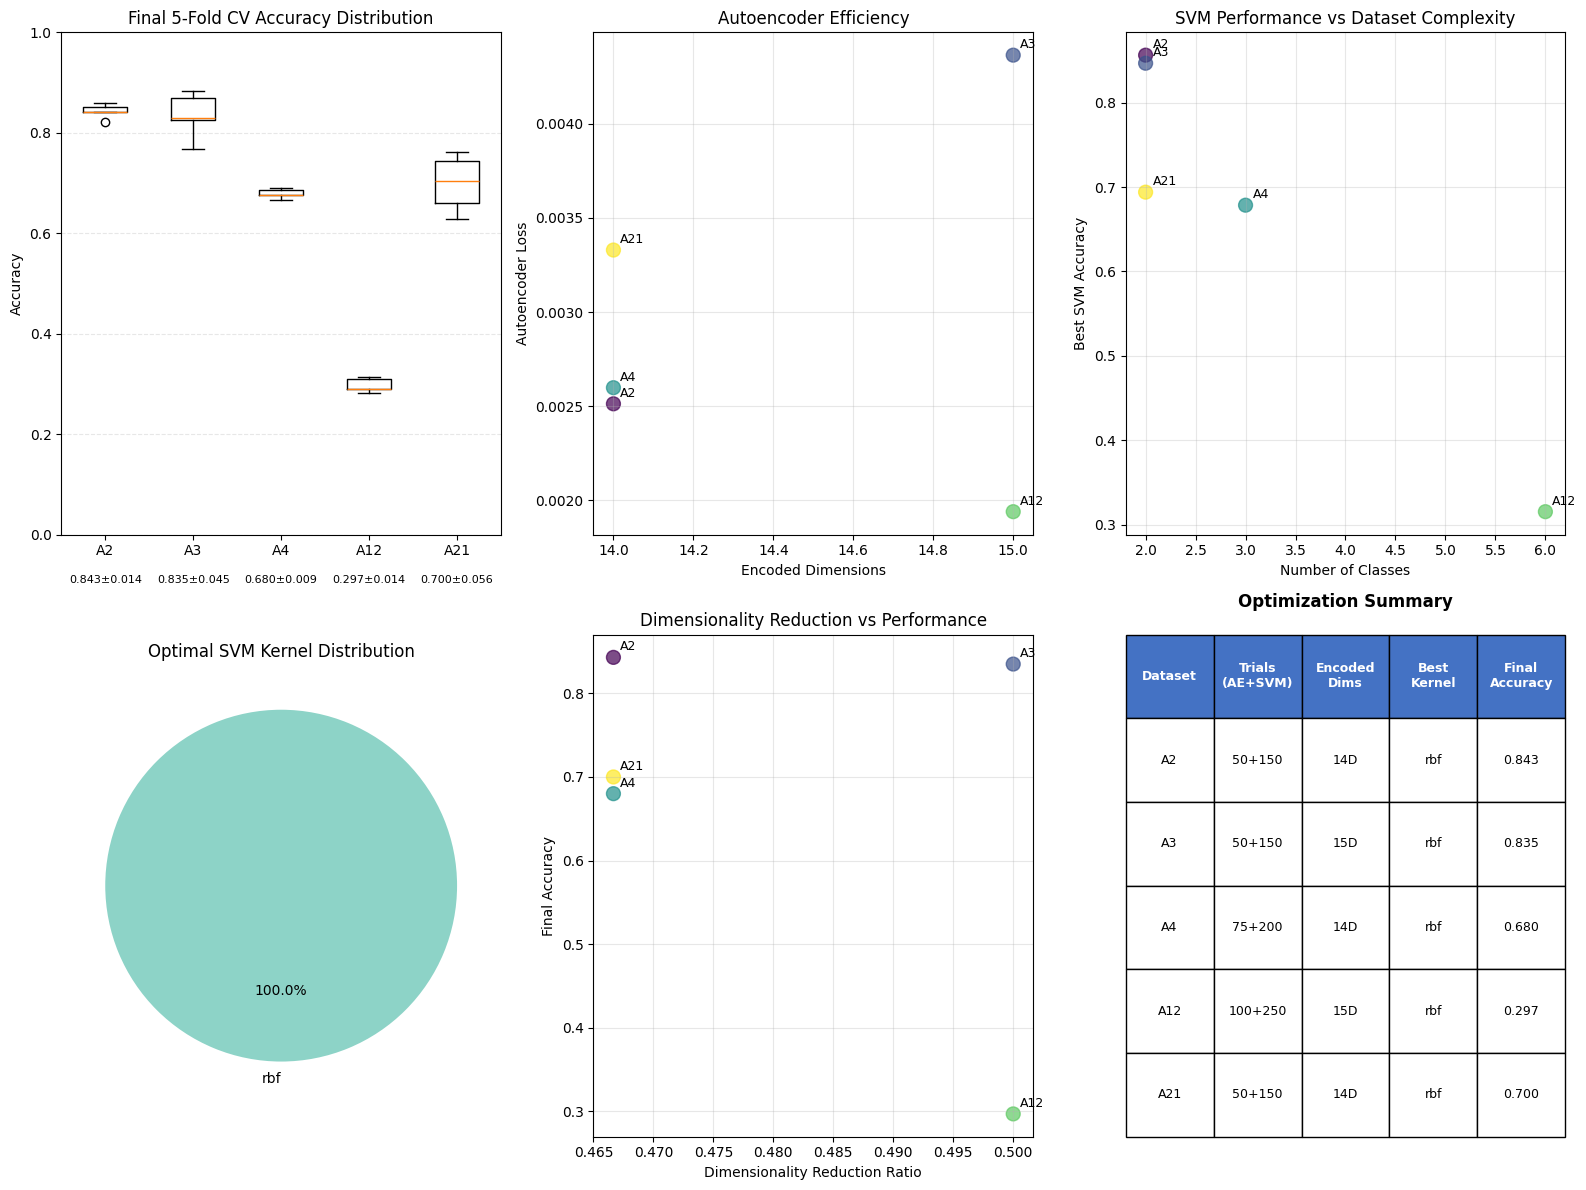

Comprehensive visualization saved to: results/comprehensive_results_visualization.png


In [11]:
# Comprehensive Results Visualization
if final_results:
    # Load fold accuracy data
    fold_df = pd.read_csv(f"{RESULTS_DIR}/final_cv_fold_accuracies.csv")
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Accuracy Boxplot
    plt.subplot(2, 3, 1)
    labels = fold_df.columns
    means = fold_df.mean()
    stds = fold_df.std()
    
    plt.boxplot([fold_df[col].dropna() for col in labels], tick_labels=labels)
    plt.ylabel("Accuracy")
    plt.title("Final 5-Fold CV Accuracy Distribution")
    plt.ylim(0, 1)
    
    # Add mean ± std annotations
    for i, (mean_val, std_val) in enumerate(zip(means, stds)):
        plt.text(i+1, -0.08, f'{mean_val:.3f}±{std_val:.3f}', 
                ha='center', va='top', fontsize=8, rotation=0)
    
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # 2. Architecture Efficiency (Loss vs Dimensionality)
    plt.subplot(2, 3, 2)
    ae_losses = [ae_results[r['Dataset']]['best_loss'] for r in final_results]
    encoded_dims = [r['Encoded_Dims'] for r in final_results]
    colors = plt.cm.viridis(np.linspace(0, 1, len(final_results)))
    
    scatter = plt.scatter(encoded_dims, ae_losses, c=colors, s=100, alpha=0.7)
    for i, result in enumerate(final_results):
        plt.annotate(result['Dataset'], (encoded_dims[i], ae_losses[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.xlabel("Encoded Dimensions")
    plt.ylabel("Autoencoder Loss")
    plt.title("Autoencoder Efficiency")
    plt.grid(True, alpha=0.3)
    
    # 3. SVM Performance vs Complexity
    plt.subplot(2, 3, 3)
    svm_scores = [svm_results[r['Dataset']]['best_accuracy'] for r in final_results]
    n_classes = [len(np.unique(targets_list[dataset_names.index(r['Dataset'])])) for r in final_results]
    
    scatter = plt.scatter(n_classes, svm_scores, c=colors, s=100, alpha=0.7)
    for i, result in enumerate(final_results):
        plt.annotate(result['Dataset'], (n_classes[i], svm_scores[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.xlabel("Number of Classes")
    plt.ylabel("Best SVM Accuracy")
    plt.title("SVM Performance vs Dataset Complexity")
    plt.grid(True, alpha=0.3)
    
    # 4. Kernel Distribution
    plt.subplot(2, 3, 4)
    kernels = [r['SVM_Kernel'] for r in final_results]
    kernel_counts = pd.Series(kernels).value_counts()
    
    colors_kernel = plt.cm.Set3(np.linspace(0, 1, len(kernel_counts)))
    plt.pie(kernel_counts.values, labels=kernel_counts.index, autopct='%1.1f%%', 
            colors=colors_kernel, startangle=90)
    plt.title("Optimal SVM Kernel Distribution")
    
    # 5. Dimensionality Reduction Effect
    plt.subplot(2, 3, 5)
    original_dims = [30] * len(final_results)  # All datasets have 30 features
    reduction_ratio = [r['Encoded_Dims'] / 30 for r in final_results]
    final_accuracies = [float(r['Accuracy'].split(' ±')[0]) for r in final_results]
    
    plt.scatter(reduction_ratio, final_accuracies, c=colors, s=100, alpha=0.7)
    for i, result in enumerate(final_results):
        plt.annotate(result['Dataset'], (reduction_ratio[i], final_accuracies[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.xlabel("Dimensionality Reduction Ratio")
    plt.ylabel("Final Accuracy")
    plt.title("Dimensionality Reduction vs Performance")
    plt.grid(True, alpha=0.3)
    
    # 6. Optimization Summary Table
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Create summary statistics
    summary_data = []
    for result in final_results:
        ae_trials = ae_results[result['Dataset']]['n_completed_trials']
        svm_trials = svm_results[result['Dataset']]['n_completed_trials']
        accuracy = float(result['Accuracy'].split(' ±')[0])
        
        summary_data.append([
            result['Dataset'],
            f"{ae_trials}+{svm_trials}",
            f"{result['Encoded_Dims']}D",
            result['SVM_Kernel'],
            f"{accuracy:.3f}"
        ])
    
    table = plt.table(
        cellText=summary_data,
        colLabels=['Dataset', 'Trials\n(AE+SVM)', 'Encoded\nDims', 'Best\nKernel', 'Final\nAccuracy'],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    plt.title("Optimization Summary", fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/comprehensive_results_visualization.png", 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Comprehensive visualization saved to: {RESULTS_DIR}/comprehensive_results_visualization.png")

else:
    print("No results available for visualization.")

In [13]:
# Final Summary and Analysis
print(f"\n{'=' * 80}")
print("COMPLETE AUTOENCODER-SVM OPTIMIZATION SUMMARY")
print(f"{'=' * 80}")

if final_results and ae_results and svm_results:
    # Time analysis
    total_time = ae_total_elapsed + svm_total_elapsed + evaluation_elapsed
    print(f"\n⏱️  TIMING ANALYSIS:")
    print(f"   Autoencoder optimization: {ae_total_elapsed:.1f}s ({ae_total_elapsed/60:.1f} min)")
    print(f"   SVM optimization: {svm_total_elapsed:.1f}s ({svm_total_elapsed/60:.1f} min)")
    print(f"   Final evaluation: {evaluation_elapsed:.1f}s")
    print(f"   Total pipeline time: {total_time:.1f}s ({total_time/60:.1f} min)")
    
    # Success rate analysis
    successful_datasets = len(final_results)
    total_datasets = len(dataset_names)
    print(f"\n✅ SUCCESS RATE:")
    print(f"   Successfully optimized: {successful_datasets}/{total_datasets} datasets ({successful_datasets/total_datasets*100:.1f}%)")
    
    # Performance analysis
    accuracies = [float(r['Accuracy'].split(' ±')[0]) for r in final_results]
    print(f"\n📊 PERFORMANCE ANALYSIS:")
    print(f"   Mean accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
    print(f"   Best dataset: {final_results[np.argmax(accuracies)]['Dataset']} ({max(accuracies):.3f})")
    print(f"   Most challenging: {final_results[np.argmin(accuracies)]['Dataset']} ({min(accuracies):.3f})")
    
    # Architecture analysis
    encoded_dims = [r['Encoded_Dims'] for r in final_results]
    reduction_ratios = [dims/30 for dims in encoded_dims]
    print(f"\n🏗️  ARCHITECTURE ANALYSIS:")
    print(f"   Average dimensionality reduction: {np.mean(reduction_ratios):.2f} ({np.mean(reduction_ratios)*100:.1f}% of original)")
    print(f"   Encoding dimensions range: {min(encoded_dims)} - {max(encoded_dims)}")
    
    # SVM kernel analysis
    kernels = [r['SVM_Kernel'] for r in final_results]
    kernel_counts = pd.Series(kernels).value_counts()
    print(f"\n🎯 SVM ANALYSIS:")
    print(f"   Most effective kernel: {kernel_counts.index[0]} ({kernel_counts.iloc[0]}/{len(kernels)} datasets)")
    print(f"   Kernel distribution: {dict(kernel_counts)}")
    
    # Trial efficiency analysis
    total_ae_trials = sum(ae_results[r['Dataset']]['n_completed_trials'] for r in final_results)
    total_svm_trials = sum(svm_results[r['Dataset']]['n_completed_trials'] for r in final_results)
    print(f"\n🔬 OPTIMIZATION EFFICIENCY:")
    print(f"   Total autoencoder trials: {total_ae_trials}")
    print(f"   Total SVM trials: {total_svm_trials}")
    print(f"   Average trials per dataset: AE={total_ae_trials/successful_datasets:.1f}, SVM={total_svm_trials/successful_datasets:.1f}")
    
    # Dataset-specific insights
    print(f"\n📈 DATASET-SPECIFIC INSIGHTS:")
    for result in final_results:
        dataset = result['Dataset']
        accuracy = float(result['Accuracy'].split(' ±')[0])
        n_classes = len(np.unique(targets_list[dataset_names.index(dataset)]))
        encoded_dims = result['Encoded_Dims']
        kernel = result['SVM_Kernel']
        
        print(f"   {dataset}: {accuracy:.3f} accuracy, {n_classes} classes, {30}→{encoded_dims}D, {kernel} kernel")
        
        # Special insights for challenging datasets
        if dataset == "A12":
            print(f"     → A12 (6-class): Achieved {accuracy:.3f} with {encoded_dims}D encoding")
        elif accuracy > 0.8:
            print(f"     → High performance dataset (>{0.8:.1f})")
    
    # Files created
    print(f"\n📁 OUTPUT FILES CREATED:")
    output_files = [
        "ae_optimization_results.json",
        "svm_optimization_results.json", 
        "final_evaluation_results.csv",
        "final_detailed_results.json",
        "final_cv_fold_accuracies.csv",
        "comprehensive_results_visualization.png"
    ]
    for file in output_files:
        print(f"   - {RESULTS_DIR}/{file}")

else:
    print("❌ No successful optimizations to summarize.")
    
print(f"\n{'=' * 80}")


COMPLETE AUTOENCODER-SVM OPTIMIZATION SUMMARY

⏱️  TIMING ANALYSIS:
   Autoencoder optimization: 861.6s (14.4 min)
   SVM optimization: 116.8s (1.9 min)
   Final evaluation: 1.1s
   Total pipeline time: 979.5s (16.3 min)

✅ SUCCESS RATE:
   Successfully optimized: 5/5 datasets (100.0%)

📊 PERFORMANCE ANALYSIS:
   Mean accuracy: 0.671 ± 0.199
   Best dataset: A2 (0.843)
   Most challenging: A12 (0.297)

🏗️  ARCHITECTURE ANALYSIS:
   Average dimensionality reduction: 0.48 (48.0% of original)
   Encoding dimensions range: 14 - 15

🎯 SVM ANALYSIS:
   Most effective kernel: rbf (5/5 datasets)
   Kernel distribution: {'rbf': 5}

🔬 OPTIMIZATION EFFICIENCY:
   Total autoencoder trials: 325
   Total SVM trials: 900
   Average trials per dataset: AE=65.0, SVM=180.0

📈 DATASET-SPECIFIC INSIGHTS:
   A2: 0.843 accuracy, 2 classes, 30→14D, rbf kernel
     → High performance dataset (>0.8)
   A3: 0.835 accuracy, 2 classes, 30→15D, rbf kernel
     → High performance dataset (>0.8)
   A4: 0.680 accura